In [8]:
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sb

In [9]:
import pandas
df = pd.read_csv('bike_buyers.csv')
print(df)

        ID Marital Status  Gender    Income  Children        Education  \
0    12496        Married  Female   40000.0       1.0        Bachelors   
1    24107        Married    Male   30000.0       3.0  Partial College   
2    14177        Married    Male   80000.0       5.0  Partial College   
3    24381         Single     NaN   70000.0       0.0        Bachelors   
4    25597         Single    Male   30000.0       0.0        Bachelors   
..     ...            ...     ...       ...       ...              ...   
995  23731        Married    Male   60000.0       2.0      High School   
996  28672         Single    Male   70000.0       4.0  Graduate Degree   
997  11809        Married     NaN   60000.0       2.0        Bachelors   
998  19664         Single    Male  100000.0       3.0        Bachelors   
999  12121         Single    Male   60000.0       3.0      High School   

         Occupation Home Owner  Cars Commute Distance         Region   Age  \
0    Skilled Manual        Yes   

# Visualisation des manquants

Nombre de données manquantes par colonne


ID                   0
Marital Status       7
Gender              11
Income               6
Children             8
Education            0
Occupation           0
Home Owner           4
Cars                 9
Commute Distance     0
Region               0
Age                  8
Purchased Bike       0
dtype: int64

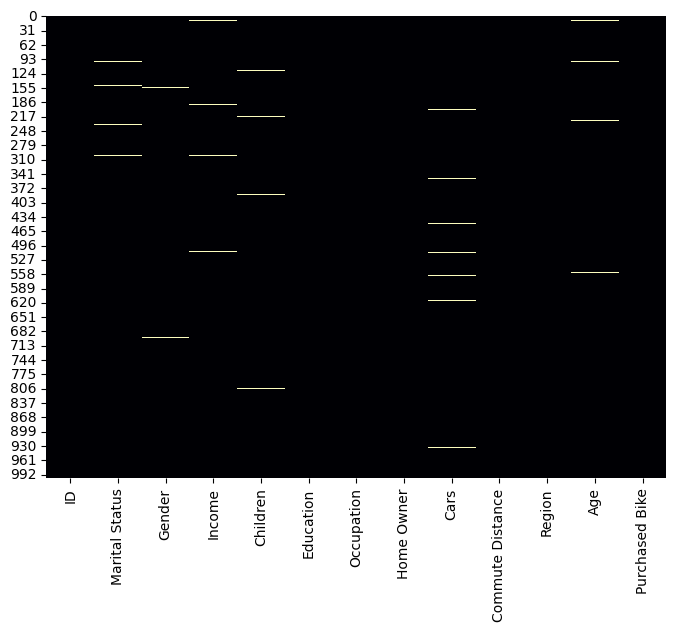

In [10]:
print("Nombre de données manquantes par colonne")
plt.figure(figsize = (8,6))
sb.heatmap(df.isnull(), cbar=False , cmap = 'magma')

df.isnull().sum()

In [11]:
print("Nombre de données dupliquées : " , df.duplicated().sum())


Nombre de données dupliquées :  0


## Cleaning

In [12]:
print(df.shape)
df_dropped = df.dropna(how = 'any')
print(df_dropped.shape)

(1000, 13)
(952, 13)


# Analyse des données

## Classification - clustering

In [13]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.cluster import KMeans
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA

In [14]:
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
numeric_cols = numeric_cols.drop('ID')

# Une liste vide pour enregistrer les inerties :  
intertia_list = []

# Notre liste de nombres de clusters : 
k_list = range(1, 10)

'''
# Pour chaque nombre de clusters : 
for k in k_list : 
        kmeans = KMeans(n_clusters=k)
        kmeans.fit(numeric_cols)
        intertia_list.append(kmeans.inertia_)
        
fig, ax = plt.subplots(1,1,figsize=(12,6))
ax.set_ylabel("intertia")
ax.set_xlabel("n_cluster")
ax = plt.plot(k_list, intertia_list)
'''

ValueError: could not convert string to float: 'Income'

In [ ]:
def clustering(df):
    cat_features = df.select_dtypes(include = ['object']).columns
    num_features = df.select_dtypes(include = ['float64', 'int64']).columns
    num_features = num_features.drop('ID')
    
    preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_features),
        ('cat', OneHotEncoder(), cat_features)
    ])

    data_preprocessed = preprocessor.fit_transform(df)

    # Clustering avec KMeans
    kmeans = KMeans(n_clusters=2)
    clusters = kmeans.fit_predict(data_preprocessed)

    # Réduction de dimension avec PCA
    pca = PCA(n_components=20)
    reduced_data = pca.fit_transform(data_preprocessed)

    # Affichage des clusters en 2D
    plt.figure(figsize=(8,6))
    plt.scatter(reduced_data[:, 0], reduced_data[:, 1], s=15)
    plt.title('Clustering visualisé avec PCA')
    plt.colorbar(label='Cluster')
    plt.show()
    
    # Ajouter les clusters au DataFrame original
    df['cluster'] = clusters
    
    # Calculer les moyennes seulement pour les colonnes numériques (sauf l'ID)
    numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
    numeric_cols = numeric_cols.drop('ID') 
    cluster_means = df.groupby('cluster')[numeric_cols].mean()

    # Analyse de 'Purchased Bike' dans chaque cluster
    purchase_counts = df.groupby('cluster')['Purchased Bike'].value_counts(normalize=True).unstack()
    
    print("\nProportion d'achats de vélo par cluster :")
    print(purchase_counts)

    # Combiner les moyennes et les proportions d'achat de vélos dans un seul DataFrame
    summary_df = pd.concat([cluster_means, purchase_counts], axis=1)
    
    # Visualisation avec un graphique en barres pour chaque colonne
    summary_df.plot(kind='bar', figsize=(12,8), subplots=True, layout=(3, 3), sharex=True, legend=False)

    plt.suptitle('Moyennes des caractéristiques et proportions d\'achats de vélos par cluster')
    plt.show()
    
    
df = clustering(df_dropped)

## Graphes